In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

In [2]:
data_narma10 = pd.read_csv("data/NARMA10.csv", header=None)

In [3]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [31]:
X = data_narma10.loc[1, :].to_numpy()
y = data_narma10.loc[0, :].to_numpy()

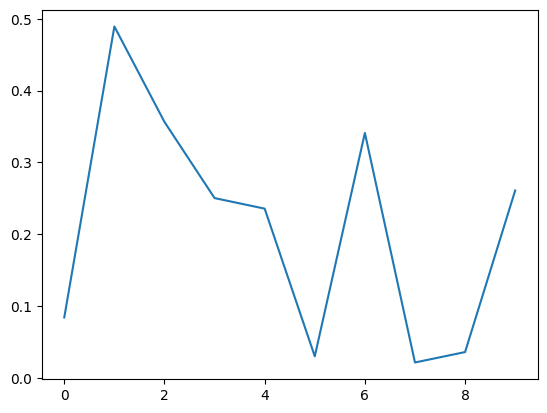

In [5]:
plt.plot(y[:10])
plt.show()

## Time Delay Neural Network

In [6]:
def construct_tdnn_data(X, t=2):
    data = []
    input_i = [0 for _ in range(t)]
    for x in X:
        input_i.pop(0)
        input_i.append(x)
        
        data.append(torch.Tensor(input_i))
        
    return torch.stack(data)

In [7]:
X_tdnn = construct_tdnn_data(X, 5)
y_tdnn = torch.Tensor(y)

In [8]:
# test split
X_test = X_tdnn[5000:]
y_test = y_tdnn[5000:]

# train split
X_train = X_tdnn[:4000]
y_train = y_tdnn[:4000]

# valid split
X_valid = X_tdnn[4000:5000]
y_valid = y_tdnn[4000:5000]

In [9]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

torch.Size([4000, 5])
torch.Size([1000, 5])
torch.Size([5000, 5])


In [10]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64)

ds_valid = torch.utils.data.TensorDataset(X_valid, y_valid)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=64)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=64)

In [11]:
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.3)
loss_fn = torch.nn.MSELoss(reduction="mean")

In [12]:
def evaluate(model, dl_valid, loss_fn):
    model.eval()
    
    valid_loss = 0.0
    n = 0
    
    for x, y in dl_valid:
        y_pred = model(x)
        loss = loss_fn(y_pred.view(-1), y)
        valid_loss += loss.item()
        n += 1
        
    return valid_loss / n

In [13]:
train_losses = []
valid_losses = []

for i in tqdm(range(100)):
    
    valid_loss = 0.0
    train_loss = 0.0
    n = 0
    model.train()
    
    for x, y in dl_train:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred.view(-1), y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        n += 1
    
    train_loss /= n
    train_losses.append(train_loss)
    valid_losses.append(evaluate(model, dl_valid, loss_fn))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.40it/s]


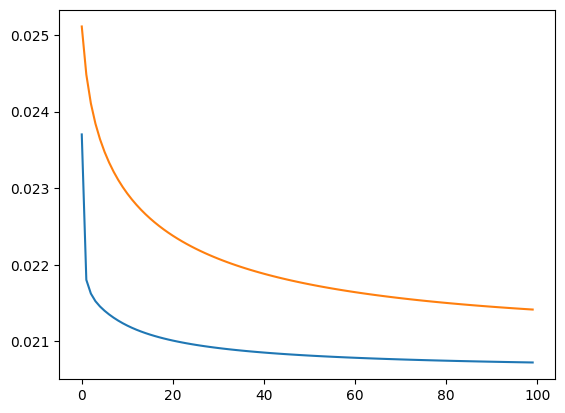

In [14]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [15]:
print(train_losses[-1])

0.02072492153162048


In [16]:
print(valid_losses[-1])

0.021415920346044004


In [17]:
print(evaluate(model, dl_test, loss_fn))

0.021310343324572226


## RNN

In [32]:
X_rnn = torch.Tensor(X).reshape((X.shape[0], 1, 1))
y_rnn = torch.Tensor(y).reshape((y.shape[0], 1, 1))

print(X_rnn.shape)
print(y_rnn.shape)

torch.Size([10000, 1, 1])
torch.Size([10000, 1, 1])


In [33]:
# test split
X_test = X_rnn[5000:]
y_test = y_rnn[5000:]

# train split
X_train = X_rnn[:4000]
y_train = y_rnn[:4000]

# valid split
X_valid = X_rnn[4000:5000]
y_valid = y_rnn[4000:5000]

In [34]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

torch.Size([4000, 1, 1])
torch.Size([1000, 1, 1])
torch.Size([5000, 1, 1])


In [92]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, act_fn='tanh'):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, nonlinearity=act_fn)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h0):
        out, hn = self.rnn(x, h0)
        out = self.fc(hn) 
        return out, hn

In [93]:
model = RNNModel(1, 30, 1, 1)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.3)
loss_fn = torch.nn.MSELoss(reduction="mean")

In [94]:
def evaluate_rnn(model, dl_valid, hidden_state, loss_fn):
    model.eval()
    
    valid_loss = 0.0
    
    y_pred, hidden_state = model(x, hidden_state)
    loss = loss_fn(y_pred.view(-1), y)
    valid_loss += loss.item()
        
    return valid_loss / n

In [95]:
train_losses = []
valid_losses = []

for i in tqdm(range(100)):
    
    valid_loss = 0.0
    train_loss = 0.0
    n = 0
    model.train()
    
    hidden_state = torch.zeros(1, 1, 30)
    
    optimizer.zero_grad()
    y_pred, hidden_state = model(X_train, hidden_state)
    loss = loss_fn(y_pred.view(-1), y)
    loss.backward()
    optimizer.step()
    hidden_state = hidden_state.detach()

    train_loss += loss.item()
    
    train_losses.append(train_loss)
    valid_losses.append(evaluate_rnn(model, dl_valid, hidden_state, loss_fn))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


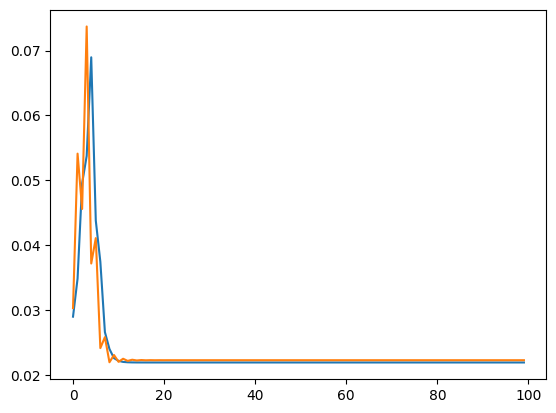

In [96]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [97]:
print(train_losses[-1])

0.02193334326148033


In [98]:
print(valid_losses[-1])

0.022283485159277916


In [99]:
print(evaluate_rnn(model, dl_test, hidden_state, loss_fn))

0.022283485159277916
